In [1]:
!pip install python-dotenv
!pip install ydata-profiling
!pip install boto3
!pip install sagemaker
!pip install s3fs
!pip install ipywidgets

  Obtaining dependency information for botocore<1.32.0,>=1.31.59 from https://files.pythonhosted.org/packages/5d/fa/fb73dceac7f2fd4ad82020696e241315e1ed9525810900ca8e35b7cf9b74/botocore-1.31.60-py3-none-any.whl.metadata
  Using cached botocore-1.31.60-py3-none-any.whl.metadata (6.0 kB)
Using cached botocore-1.31.60-py3-none-any.whl (11.2 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.31.17
    Uninstalling botocore-1.31.17:
      Successfully uninstalled botocore-1.31.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.5.4 requires botocore<1.31.18,>=1.31.17, but you have botocore 1.31.60 which is incompatible.
  Obtaining dependency information for botocore<1.31.18,>=1.31.17 from https://files.pythonhosted.org/packages/3d/e5/32a88f5a95e3d43c2e3ed86fc1ffdb715547a04f95a51d00e1185af63b0c/botocore-1.31.17-py3-none-any

In [2]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from s3fs.core import S3FileSystem
from dotenv import load_dotenv
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from load_data import load_data
from visualize_data import visualize_data
from correlation_analysis import correlation_analysis
from select_model import select_model



my_region = boto3.session.Session().region_name

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/lanre.bakare/Library/Application Support/sagemaker/config.yaml


/Users/lanre.bakare/Documents/internal-projects/streaming-data-platform/venv/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/lanre.bakare/Documents/internal-projects/streaming-data-platform/venv/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [3]:
load_dotenv(".env")
role = get_execution_role()

model_name = os.getenv("model_name").replace(" ", "").lower()
model_features = [x.strip() for x in os.environ["features"].split(",")]
target = os.getenv("target")
print(model_name, model_features, target)

bucket= os.getenv("bucket")
data_key = os.getenv("key")
data_location = 's3://{}/{}'.format(bucket, data_key)
print(data_location)

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/lanre.bakare/Library/Application Support/sagemaker/config.yaml


INFO:botocore.tokens:Loading cached SSO token for my-sso


randomforestregressor ['Bakerloo', 'dayOfWeek', 'hour', 'minute'] Bakerloo10
s3://streaming-data-platform-ml-data/bakerloo.csv


In [4]:
df = load_data(data_location)

INFO:aiobotocore.tokens:Loading cached SSO token for my-sso


In [5]:
def data_overview(df):
    print("First 5 rows of data:\n", df.head())
    print("\nSummary statistics:\n", df.describe())
    print("\nMissing values:\n", df.isnull().sum())

In [6]:
data_overview(df.copy())

First 5 rows of data:
    Bakerloo  Bakerloo10  dayOfWeek  hour  minute
0        23        24.0          1    13      38
1        23        22.0          1    13      40
2        23        24.0          1    13      41
3        23        24.0          1    13      42
4        23        24.0          1    13      43

Summary statistics:
           Bakerloo   Bakerloo10    dayOfWeek         hour       minute
count  7127.000000  7127.000000  7127.000000  7127.000000  7127.000000
mean     20.013189    20.016416     2.876947    13.039568    29.316402
std       7.552518     7.553617     2.029500     6.043518    17.350870
min       1.000000     1.000000     0.000000     0.000000     0.000000
25%      19.000000    19.000000     1.000000     8.000000    14.000000
50%      22.000000    22.000000     3.000000    13.000000    29.000000
75%      24.000000    24.000000     5.000000    18.000000    44.000000
max      31.000000    31.000000     6.000000    23.000000    59.000000

Missing values:
 Bake

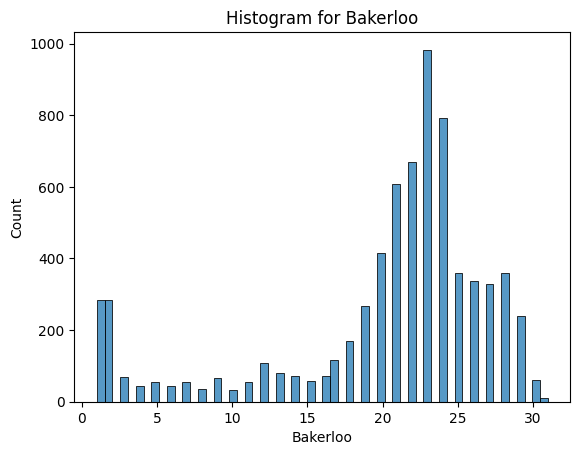

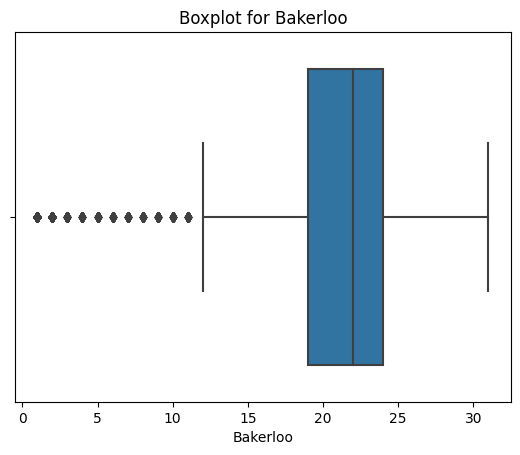

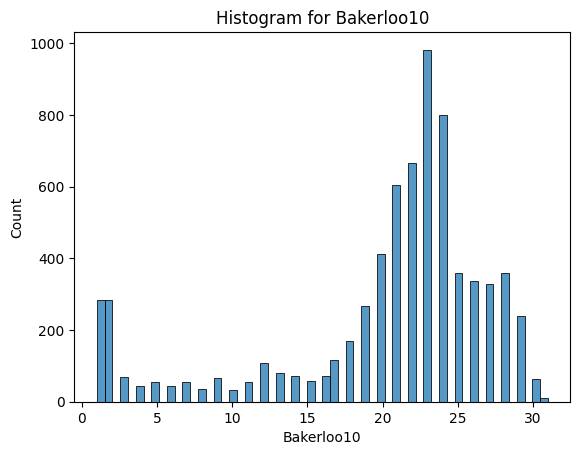

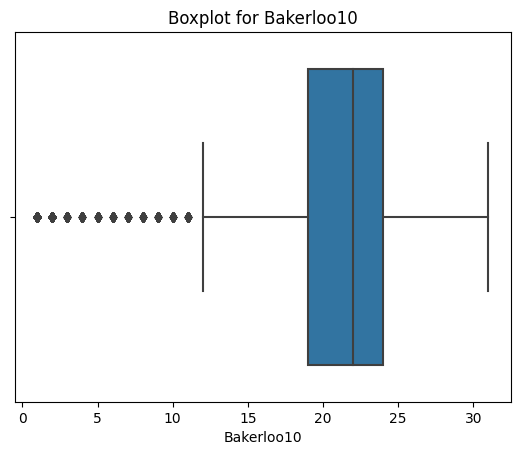

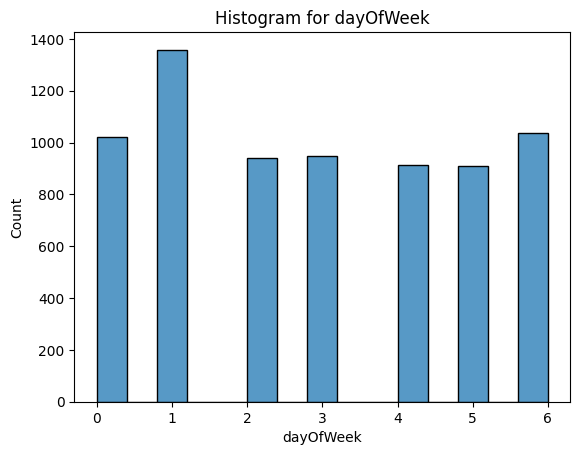

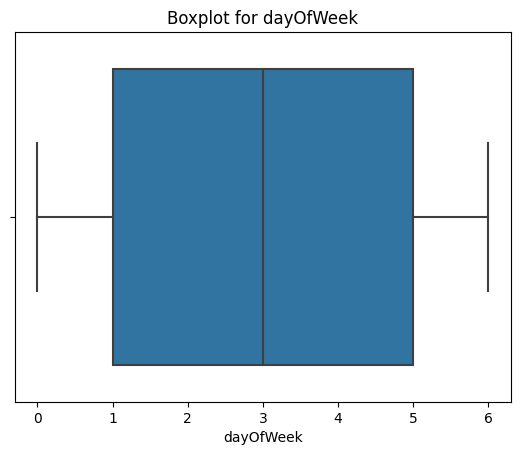

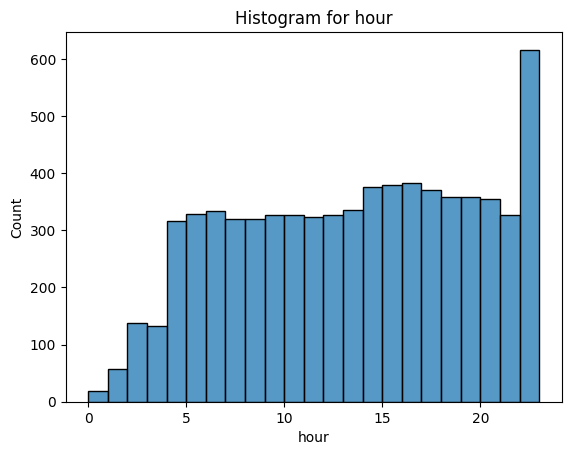

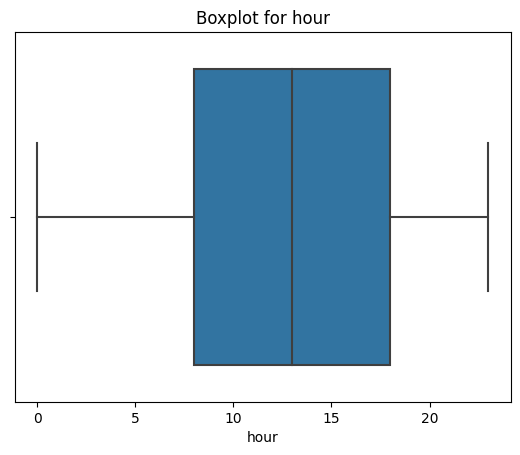

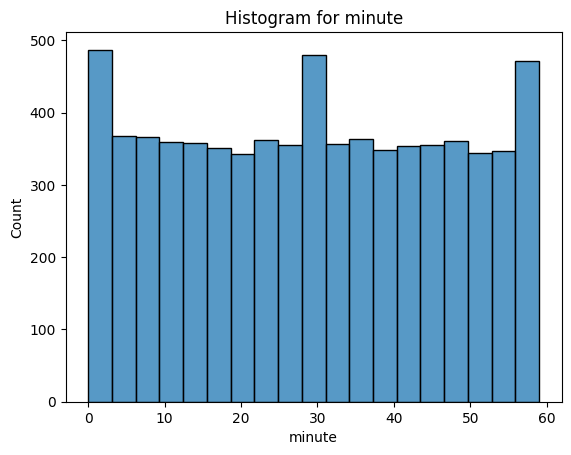

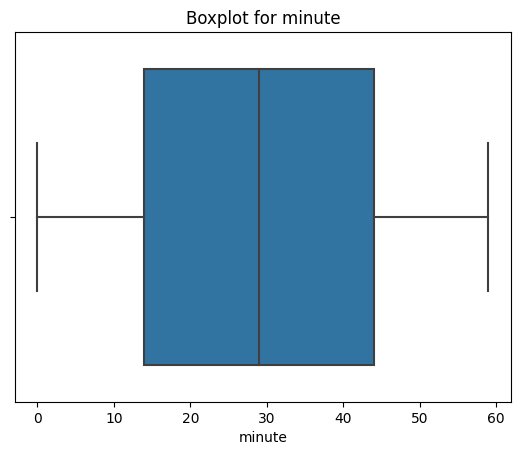

In [7]:
visualize_data(df.copy())

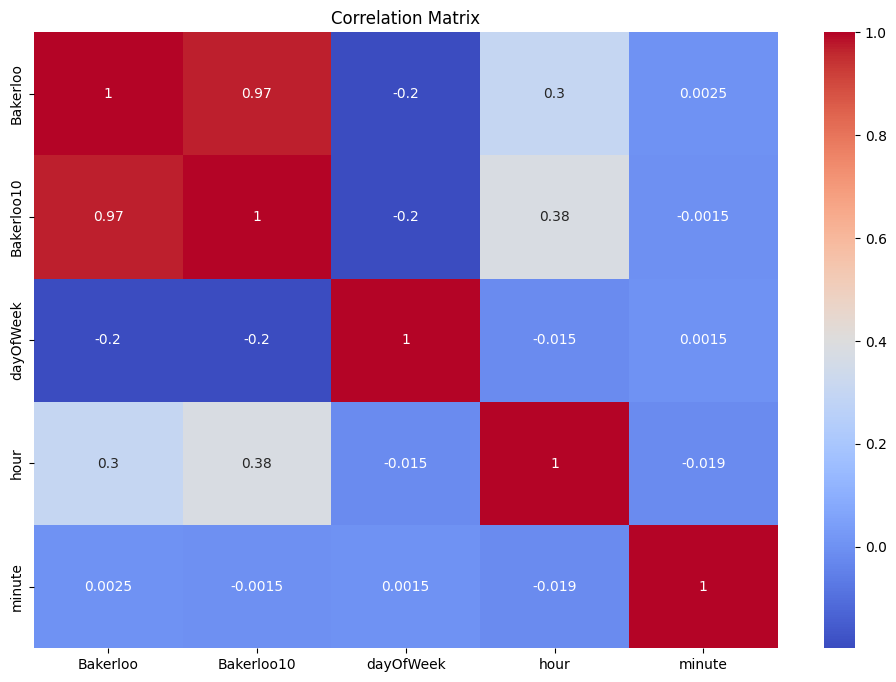

In [8]:
correlation_analysis(df.copy())

In [9]:
def data_profile(df):
    profile = ProfileReport(df, explorative=True)
    profile.to_widgets()

In [10]:
data_profile(df.copy())

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
regression_models=["linearregression", "ridge", "lasso", "svr", "decisiontreeregressor", "randomforestregressor", "kneighborsregressor", "adaboostregressor"]
time_series_models = ["autoregression", "movingaverage", "autoregressivemovingaverage", "autoregressiveintegratedmovingaverage", "seasonalautoregressiveintegratedmovingaverage", "vectorautoregression"]

In [12]:
# X_col need to be supplied from the terraform, I need to find out ways to save lists in env variable.

def select_X_y(df: pd.DataFrame, X_cols: list, y_col: str) -> (pd.DataFrame, pd.Series):
    """
    Selects feature and target columns from a DataFrame.

    Parameters:
        df (pd.DataFrame): The original DataFrame
        X_cols (list): List of feature column names
        y_col (str): Target column name

    Returns:
        X (pd.DataFrame): DataFrame containing only the feature columns
        y (pd.Series): Series containing only the target column
    """
    X = df[X_cols]
    y = df[y_col]
    
    return X, y

In [13]:

def split_train_test(X: pd.DataFrame, y: pd.Series, test_size: float = 0.2) -> (pd.DataFrame, pd.DataFrame, pd.Series, pd.Series):
    """
    Splits the features and target into training and testing sets.

    Parameters:
        X (pd.DataFrame): Features DataFrame
        y (pd.Series): Target Series
        test_size (float): Proportion of data to be used for testing (default is 0.2)

    Returns:
        X_train (pd.DataFrame): Training features
        X_test (pd.DataFrame): Testing features
        y_train (pd.Series): Training target
        y_test (pd.Series): Testing target
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test




In [14]:
if model_name in regression_models: 
    print(type(model_features))
    features, target = select_X_y(df=df.copy(), X_cols=model_features, y_col=target)
    print(features.head())
    print(target.head())
    X_train, X_test, y_train, y_test = split_train_test(features, target)
model = select_model(model_name)

INFO:root:Using RandomForestRegressor


<class 'list'>
   Bakerloo  dayOfWeek  hour  minute
0        23          1    13      38
1        23          1    13      40
2        23          1    13      41
3        23          1    13      42
4        23          1    13      43
0    24.0
1    22.0
2    24.0
3    24.0
4    24.0
Name: Bakerloo10, dtype: float64


In [15]:
def fit_and_predict(df: pd.DataFrame, X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, model: object) -> pd.Series:
    """_summary_

    Args:
        df (pd.DataFrame): _description_
        X_train (pd.DataFrame): _description_
        y_train (Pd.DataFrame): _description_
        model (obj): _description_

    Returns:
        pd.Series: _description_
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

In [16]:
from sklearn.metrics import mean_squared_error
def evaluate(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

In [17]:
y_pred = fit_and_predict(df.copy(), X_train.copy(), y_train.copy(), X_test.copy(), model)
print(len(y_pred), len(y_test))
mse = evaluate(y_test, y_pred.copy())
print(mse)

1426 1426
Mean Squared Error: 1.0908125157239381
None


Train test split will not work with time series. You will want to slice your data without necessarily doing a train test split. Add a function to check if the data is time series or not. If it is not apply your code, else apply the one from Konrad's notebook. 

You can use switch statements instead of the if statements that you have there. Clean it up more 
You should add RSE as well with the MSE that you have. 

Write tests for some of the code and then add them to the CI/CD pipelines.  Especially for those that dont need visualization. 
For MVP, sklearn can be fine, you can use some of the container images that are already available for sagemaker. 